# Optimising single country

Based on https://model.energy/.

Code analyses shadow prices for storage afterwards.

Alter assumptions in assumptions.

In [163]:
import requests, json, time, yaml

import pypsa

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

In [164]:
base = "https://model.energy/"

In [165]:
ct = "DE"

In [166]:
assumptions = {'battery': False,
 'battery_energy_cost': '142',
 'battery_energy_discount': '5',
 'battery_energy_fom': '3',
 'battery_energy_lifetime': '15',
 'battery_power_cost': '160',
 'battery_power_discount': '5',
 'battery_power_efficiency_charging': '95',
 'battery_power_efficiency_discharging': '95',
 'battery_power_fom': '3',
 'battery_power_lifetime': '15',
 'cf_exponent': '2',
 'co2_emissions': '100',
 'co2_limit': False,
 'dispatchable1': True,
 'dispatchable1_cost': '0',
 'dispatchable1_discount': '10',
 'dispatchable1_emissions': '500',
 'dispatchable1_fom': '3',
 'dispatchable1_lifetime': '25',
 'dispatchable1_marginal_cost': '1000',
 'dispatchable2': False,
 'dispatchable2_cost': '6000',
 'dispatchable2_discount': '10',
 'dispatchable2_emissions': '0',
 'dispatchable2_fom': '3',
 'dispatchable2_lifetime': '25',
 'dispatchable2_marginal_cost': '10',
 'frequency': '3',
 'hydrogen': True,
 'hydrogen_electrolyser_cost': '600',
 'hydrogen_electrolyser_discount': '5',
 'hydrogen_electrolyser_efficiency': '62',
 'hydrogen_electrolyser_fom': '3',
 'hydrogen_electrolyser_lifetime': '20',
 'hydrogen_energy_cost': 0,
 'hydrogen_energy_discount': '5',
 'hydrogen_energy_fom': '14',
 'hydrogen_energy_lifetime': '25',
 'hydrogen_load': '0',
 'hydrogen_turbine_cost': '830',
 'hydrogen_turbine_discount': '5',
 'hydrogen_turbine_efficiency': '58',
 'hydrogen_turbine_fom': '3',
 'hydrogen_turbine_lifetime': '25',
 'job_type': 'weather',
 'load': '100',
 'location': f'country:{ct}',
 'location_name': "irrelevant",
 'solar': True,
 'solar_cost': '300',
 'solar_discount': '5',
 'solar_fom': '3',
 'solar_lifetime': '25',
 'solar_max': '10000000',
 'solar_min': '0',
 'version': '190929',
 'wind': 'true',
 'wind_cost': '1040',
 'wind_discount': '5',
 'wind_fom': '3',
 'wind_lifetime': '25',
 'wind_max': '10000000',
 'wind_min': '0',
 'year': '2011'}

## Download wind and solar availability

In [167]:
#if the job was already calculated, this will return results immediately; otherwise it returns a jobid
r = requests.post(base + "jobs", json=assumptions)

In [168]:
ts_json = json.loads(r.text)

In [169]:
pu = pd.DataFrame(index=pd.date_range("{}-01-01".format(assumptions["year"]),"{}-12-31 23:00".format(assumptions["year"]),
                              freq="1H"))

for t in ["onwind","solar"]:
    pu[t] = ts_json[t+"_pu"]

<AxesSubplot: >

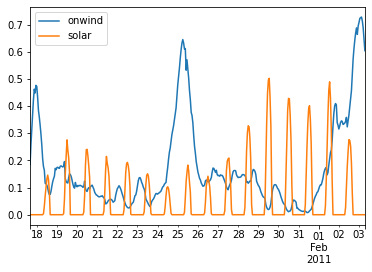

In [170]:
pu.iloc[400:800].plot()

## Now optimise a single node over one weather year

In [171]:
config = {"float_upper_limit" : 1.e+7,
          "weather_years" : [2011,2012,2013,2014]}

    
    
booleans = ["wind","solar","battery","hydrogen","dispatchable1","dispatchable2","co2_limit"]

floats = ["cf_exponent","load","hydrogen_load","wind_cost","solar_cost","battery_energy_cost",
          "wind_fom","wind_lifetime","wind_discount",
          "solar_fom","solar_lifetime","solar_discount",
          "battery_energy_fom","battery_energy_lifetime","battery_energy_discount",
          "battery_power_fom","battery_power_lifetime","battery_power_discount",
          "battery_power_efficiency_charging","battery_power_efficiency_discharging",
          "hydrogen_energy_fom","hydrogen_energy_lifetime","hydrogen_energy_discount",
          "hydrogen_electrolyser_fom","hydrogen_electrolyser_lifetime","hydrogen_electrolyser_discount",
          "hydrogen_turbine_fom","hydrogen_turbine_lifetime","hydrogen_turbine_discount",
          "battery_power_cost","hydrogen_electrolyser_cost",
          "hydrogen_energy_cost",
          "hydrogen_electrolyser_efficiency",
          "hydrogen_turbine_cost",
          "hydrogen_turbine_efficiency",
          "dispatchable1_cost",
          "dispatchable1_marginal_cost",
          "dispatchable1_emissions",
          "dispatchable1_discount",
          "dispatchable1_fom","dispatchable1_lifetime",
          "dispatchable2_cost",
          "dispatchable2_marginal_cost",
          "dispatchable2_emissions",
          "dispatchable2_discount",
          "dispatchable2_fom","dispatchable2_lifetime",
          "co2_emissions",
          "wind_min",
          "solar_min",
          "wind_max",
          "solar_max"]


ints = ["year","frequency","version"]

strings = ["location"]



def sanitise_assumptions(assumptions):
    """
    Fix types of assumptions and check they are in correct
    range.

    Parameters
    ----------
    assumptions : dict
        Assumptions (location, technical and economic parameters)

    Returns
    -------
    error_message : None or string
        If there was an error, details of the error
    assumptions : dict
        If there was no error, the clean type-safe assumptions
    """
    for key in strings+ints+booleans+floats:
        if key not in assumptions:
            return f"{key} missing from assumptions", None

    for key in booleans:
        try:
            assumptions[key] = bool(assumptions[key])
        except:
            return "{} {} could not be converted to boolean".format(key,assumptions[key]), None

    for key in floats:
        try:
            assumptions[key] = float(assumptions[key])
        except:
            return "{} {} could not be converted to float".format(key,assumptions[key]), None

        if assumptions[key] < 0 or assumptions[key] > config["float_upper_limit"]:
            return "{} {} was not in the valid range [0,{}]".format(key,assumptions[key],config["float_upper_limit"]), None

    for key in ints:
        try:
            assumptions[key] = int(assumptions[key])
        except:
            return "{} {} could not be converted to an integer".format(key,assumptions[key]), None

    for key in strings:
        assumptions[key] = str(assumptions[key])

    if assumptions["frequency"] < 1 or assumptions["frequency"] > 8760:
        return "Frequency {} is not in the valid range [1,8760]".format(assumptions["frequency"]), None

    if assumptions["year"] not in config["weather_years"]:
        return "Year {} not in valid range".format(assumptions["year"]), None

    if assumptions["load"] == 0 and assumptions["hydrogen_load"] == 0:
        return "No load", None

    if not assumptions["hydrogen"] and assumptions["hydrogen_load"] != 0:
        return "Non-zero hydrogen load is defined without activating hydrogen infrastructure", None

    return None, assumptions

In [172]:


def annuity(lifetime,rate):
    if rate == 0.:
        return 1/lifetime
    else:
        return rate/(1. - 1. / (1. + rate)**lifetime)


assumptions_df = pd.DataFrame(columns=["FOM","fixed","discount rate","lifetime","investment"],
                              dtype=float)

def run_optimisation(assumptions, pu):
    """Needs cleaned-up assumptions and pu.
    return results_overview, results_series, error_msg"""


    Nyears = 1

    techs = ["wind","solar","battery_energy","battery_power","hydrogen_electrolyser","hydrogen_energy","hydrogen_turbine","dispatchable1","dispatchable2"]

    for item in techs:
        assumptions_df.at[item,"discount rate"] = assumptions[item + "_discount"]/100.
        assumptions_df.at[item,"investment"] = assumptions[item + "_cost"]
        assumptions_df.at[item,"FOM"] = assumptions[item + "_fom"]
        assumptions_df.at[item,"lifetime"] = assumptions[item + "_lifetime"]

    #convert costs from per kW to per MW
    assumptions_df["investment"] *= 1000.
    assumptions_df["fixed"] = [(annuity(v["lifetime"],v["discount rate"])+v["FOM"]/100.)*v["investment"]*Nyears for i,v in assumptions_df.iterrows()]

    print('Starting task for {} with assumptions {}'.format(assumptions["location"],assumptions_df))

    network = pypsa.Network()

    snapshots = pd.date_range("{}-01-01".format(assumptions["year"]),"{}-12-31 23:00".format(assumptions["year"]),
                              freq=str(assumptions["frequency"])+"H")

    network.set_snapshots(snapshots)

    network.snapshot_weightings = pd.Series(float(assumptions["frequency"]),index=network.snapshots)

    network.add("Bus","elec")
    network.add("Load","load",
                bus="elec",
                p_set=assumptions["load"])

    if assumptions["solar"]:
        network.add("Generator","solar",
                    bus="elec",
                    p_max_pu = pu["solar"],
                    p_nom_extendable = True,
                    p_nom_min = assumptions["solar_min"],
                    p_nom_max = assumptions["solar_max"],
                    marginal_cost = 0.1, #Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
                    capital_cost = assumptions_df.at['solar','fixed'])

    if assumptions["wind"]:
        network.add("Generator","wind",
                    bus="elec",
                    p_max_pu = pu["onwind"],
                    p_nom_extendable = True,
                    p_nom_min = assumptions["wind_min"],
                    p_nom_max = assumptions["wind_max"],
                    marginal_cost = 0.2, #Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
                    capital_cost = assumptions_df.at['wind','fixed'])

    for i in range(1,3):
        name = "dispatchable" + str(i)
        if assumptions[name]:
            network.add("Carrier",name,
                        co2_emissions=assumptions[name+"_emissions"])
            network.add("Generator",name,
                        bus="elec",
                        carrier=name,
                        p_nom_extendable=True,
                        marginal_cost=assumptions[name+"_marginal_cost"],
                        capital_cost=assumptions_df.at[name,'fixed'])

    if assumptions["battery"]:

        network.add("Bus","battery")

        network.add("Store","battery_energy",
                    bus = "battery",
                    e_nom_extendable = True,
                    e_cyclic=True,
                    capital_cost=assumptions_df.at['battery_energy','fixed'])

        network.add("Link","battery_power",
                    bus0 = "elec",
                    bus1 = "battery",
                    efficiency = assumptions["battery_power_efficiency_charging"]/100.,
                    p_nom_extendable = True,
                    capital_cost=assumptions_df.at['battery_power','fixed'])

        network.add("Link","battery_discharge",
                    bus0 = "battery",
                    bus1 = "elec",
                    p_nom_extendable = True,
                    efficiency = assumptions["battery_power_efficiency_discharging"]/100.)

        def extra_functionality(network,snapshots):

            link_p_nom = get_var(network, "Link", "p_nom")

            lhs = linexpr((1,link_p_nom["battery_power"]),
                          (-network.links.loc["battery_discharge", "efficiency"],
                           link_p_nom["battery_discharge"]))
            define_constraints(network, lhs, "=", 0, 'Link', 'charger_ratio')
    else:
        def extra_functionality(network,snapshots):
            pass

    if assumptions["hydrogen"]:

        network.add("Bus",
                     "hydrogen",
                     carrier="hydrogen")

        network.add("Load","hydrogen_load",
                    bus="hydrogen",
                    p_set=assumptions["hydrogen_load"])

        network.add("Link",
                    "hydrogen_electrolyser",
                    bus1="hydrogen",
                    bus0="elec",
                    p_nom_extendable=True,
                    efficiency=assumptions["hydrogen_electrolyser_efficiency"]/100.,
                    capital_cost=assumptions_df.at["hydrogen_electrolyser","fixed"])

        network.add("Link",
                     "hydrogen_turbine",
                     bus0="hydrogen",
                     bus1="elec",
                     p_nom_extendable=True,
                     efficiency=assumptions["hydrogen_turbine_efficiency"]/100.,
                     capital_cost=assumptions_df.at["hydrogen_turbine","fixed"]*assumptions["hydrogen_turbine_efficiency"]/100.)  #NB: fixed cost is per MWel

        network.add("Store",
                     "hydrogen_energy",
                     bus="hydrogen",
                     e_nom_extendable=True,
                     e_cyclic=True,
                     capital_cost=assumptions_df.at["hydrogen_energy","fixed"])

    if assumptions["co2_limit"]:
        network.add("GlobalConstraint","co2_limit",
                    sense="<=",
                    constant=assumptions["co2_emissions"]*assumptions["load"]*network.snapshot_weightings.objective.sum())

    network.consistency_check()

    solver_name = "gurobi"
    solver_options = {}
    #solver_name = "gurobi"
    #solver_options = {"method": 2, # barrier
    #                  "crossover": 0}
                      #"BarConvTol": 1.e-5,
                      #"AggFill": 0,
                      #"PreDual": 0,
                      #"GURO_PAR_BARDENSETHRESH": 200}

    #formulation = "kirchhoff"
    #status, termination_condition = network.lopf(pyomo=False,
    #                                             solver_name=solver_name,
    #                                             solver_options=solver_options,
    #                                             formulation=formulation,
    #                                             extra_functionality=extra_functionality)

    network.optimize.create_model()
    
    if assumptions["battery"]:
        network.model.add_constraints(network.model["Link-p_nom"].loc["battery_power"]
                                      -network.links.loc["battery_discharge", "efficiency"]*
                                      network.model["Link-p_nom"].loc["battery_discharge"] == 0,
                                      name='charger_ratio')
    status, termination_condition = network.optimize.solve_model(solver_name=solver_name,
                                                                 solver_options=solver_options)
    
    
    print(status,termination_condition)

    if termination_condition in ["infeasible","infeasible or unbounded"]:
        return None, None, "Problem was infeasible"
    elif termination_condition in ["numeric"]:
        return None, None, "Numerical trouble encountered, problem could be infeasible"
    elif status == "ok" and termination_condition == "optimal":
        pass
    elif status == "warning" and termination_condition == "suboptimal":
        pass
    else:
        return None, None, "Job failed to optimise correctly"
    
    return network

In [173]:
error, assumptions = sanitise_assumptions(assumptions)
n = run_optimisation(assumptions, pu)

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`


Starting task for country:DE with assumptions                         FOM          fixed  discount rate  lifetime  \
wind                    3.0  104990.555591           0.05      25.0   
solar                   3.0   30285.737190           0.05      25.0   
battery_energy          3.0   17940.604841           0.05      15.0   
battery_power           3.0   20214.766017           0.05      15.0   
hydrogen_electrolyser   3.0   66145.552314           0.05      20.0   
hydrogen_energy        14.0       0.000000           0.05      25.0   
hydrogen_turbine        3.0   83790.539558           0.05      25.0   
dispatchable1           3.0       0.000000           0.10      25.0   
dispatchable2           3.0  841008.433140           0.10      25.0   

                       investment  
wind                    1040000.0  
solar                    300000.0  
battery_energy           142000.0  
battery_power            160000.0  
hydrogen_electrolyser    600000.0  
hydrogen_energy            

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 233.72it/s]

Read LP format model from file /tmp/linopy-problem-os9z4oqd.lp
Reading time = 0.06 seconds
obj: 43808 rows, 20446 columns, 83220 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 43808 rows, 20446 columns and 83220 nonzeros
Model fingerprint: 0xbbfcbcda
Coefficient statistics:
  Matrix range     [1e-03, 3e+00]
  Objective range  [3e-01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+07]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...



Presolve removed 27756 rows and 4390 columns
Presolve time: 0.04s
Presolved: 16052 rows, 16056 columns, 45236 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 3.210e+04
 Factor NZ  : 1.744e+05 (roughly 14 MBytes of memory)
 Factor Ops : 2.751e+06 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.35552638e+11 -2.66361204e+11  4.16e+04 1.33e+03  4.31e+08     0s
   1   8.24187187e+10 -5.47106806e+10  1.85e+03 4.07e+03  7.95e+07     0s
   2   5.81767771e+10 -2.60280851e+09  5.46e-11 2.39e+02  5.66e+06     0s
   3   1.42829101e+10 -2.10491163e+08  1.75e-10 2.15e+01  7.80e+05     0s
   4   5.55507917e+09 -6.39110500e+07  5.75e-10 8.05e+00  2.66e+05     0s
   5   2.32979343e+09 -1.41956025e+07  5.38e-09 3.30e+00  1.04e+05     0s
   6   7.06280142e+08  9.39555510e+06  1.90e-09 1.07e+00  2.98e+04     0s
   7   2.11345044e+08  1

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 20446 primals, 43808 duals
Objective: 6.37e+07
Solver model: available
Solver message: 2



ok optimal


In [174]:
n.objective,n.objective/n.snapshot_weightings["generators"].sum()/assumptions["load"]

(63687329.63870253, 72.70243109440928)

In [175]:
n.generators.p_nom_opt

Generator
solar            401.248383
wind             327.821085
dispatchable1      4.261674
Name: p_nom_opt, dtype: float64

In [176]:
n.links.p_nom_opt

Link
hydrogen_electrolyser    136.359002
hydrogen_turbine         158.848783
Name: p_nom_opt, dtype: float64

In [177]:
links_to_el = n.links.index[n.links.bus1 == "elec"]
links_to_el

Index(['hydrogen_turbine'], dtype='object', name='Link')

In [178]:
links_from_el = n.links.index[n.links.bus0 == "elec"]
links_from_el

Index(['hydrogen_electrolyser'], dtype='object', name='Link')

/home/tom/miniconda3/envs/tom/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1437: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


(-163.63080297034273, 283.63080297034276)

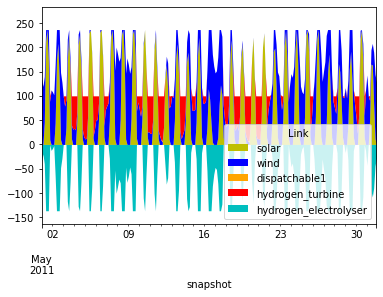

In [179]:
start = "2011-05"
end = "2011-05"

colors = {"solar" : "y",
          "wind" : "b",
          "battery_discharge" : "grey",
          "battery_power" : "grey",
          "hydrogen_turbine" : "r",
          "hydrogen_electrolyser" : "c",
          "dispatchable1": "orange",
          "dispatchable2": "brown"}


positive = pd.concat((n.generators_t.p,-n.links_t.p1[links_to_el]),axis=1)

negative = n.links_t.p0[links_from_el]

fig, ax = plt.subplots()
fig.set_size_inches((6,4))

positive.loc[start:end].plot(kind="area",stacked=True,ax=ax,color=[colors[i] for i in positive.columns],linewidth=0)

(-negative.loc[start:end]).plot(kind="area",stacked=True,ax=ax,color=[colors[i] for i in negative.columns],linewidth=0)

ax.set_ylim([-1.2*negative.max().max(),1.2*positive.max().max()])

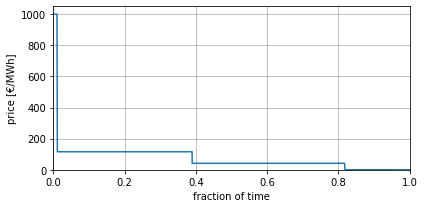

In [186]:
fig, ax = plt.subplots()
fig.set_size_inches((6,3))

s = n.buses_t.marginal_price["elec"].sort_values(ascending=False)
s.index = np.arange(0,1,1/len(s.index))
s.plot(grid=True,ylim=[0,1050],xlim=[0,1],ax=ax)

ax.set_xlabel("fraction of time")
ax.set_ylabel("price [€/MWh]")

fig.tight_layout()
fig.savefig("price_duration-storage.pdf",transparent=True)

<AxesSubplot: xlabel='snapshot'>

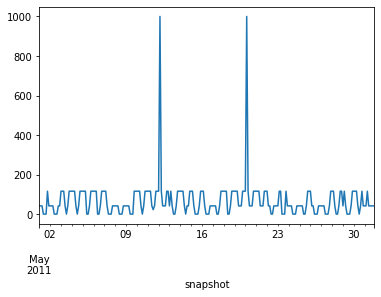

In [187]:
n.buses_t.marginal_price["elec"].loc[start:end].plot()

<AxesSubplot: xlabel='snapshot'>

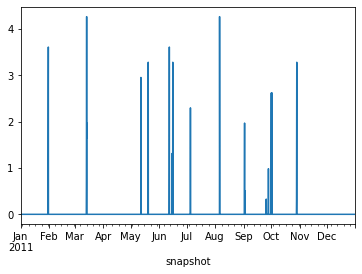

In [188]:
n.generators_t.p["dispatchable1"].plot()

<AxesSubplot: xlabel='snapshot'>

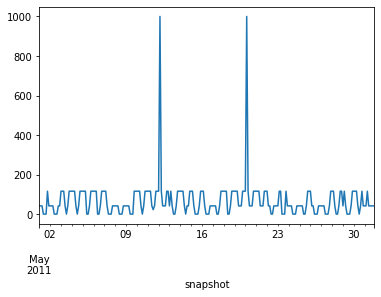

In [189]:
n.buses_t.marginal_price["elec"].loc[start:end].plot()

67.30210733398916


<AxesSubplot: xlabel='snapshot'>

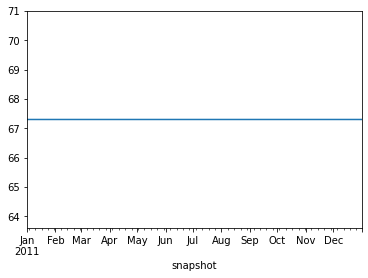

In [190]:
print(n.stores_t.mu_energy_balance["hydrogen_energy"].mean())
n.stores_t.mu_energy_balance["hydrogen_energy"].plot()

In [191]:
n.buses_t.marginal_price.mean()

Bus
elec        72.702431
hydrogen    67.302107
dtype: float64

In [192]:
n.generators_t.p.multiply(n.buses_t.marginal_price["elec"],axis=0).sum()/n.generators_t.p.sum()

Generator
solar              28.744419
wind               46.118322
dispatchable1    1000.000000
dtype: float64

In [193]:
(n.generators.capital_cost*n.generators.p_nom_opt)/n.generators_t.p.multiply(n.snapshot_weightings["generators"],axis=0).sum()

Generator
solar            28.644419
wind             45.918322
dispatchable1     0.000000
dtype: float64

In [194]:
n.generators.marginal_cost

Generator
solar               0.1
wind                0.2
dispatchable1    1000.0
Name: marginal_cost, dtype: float64

In [195]:
mv_links = n.links_t.p0.multiply(n.buses_t.marginal_price["elec"],axis=0).sum()/n.links_t.p0.sum()
mv_links

Link
hydrogen_electrolyser     22.342817
hydrogen_turbine         162.175939
dtype: float64

In [196]:
cap_links_p1 = -(n.links.capital_cost*n.links.p_nom_opt)/(n.links_t.p1.multiply(n.snapshot_weightings["generators"],axis=0).sum())
cap_links_p1

Link
hydrogen_electrolyser    31.265306
hydrogen_turbine         46.137823
dtype: float64

In [197]:
cap_links_p0 = (n.links.capital_cost*n.links.p_nom_opt)/(n.links_t.p0.multiply(n.snapshot_weightings["generators"],axis=0).sum())
cap_links_p0

Link
hydrogen_electrolyser    19.384490
hydrogen_turbine         26.759937
dtype: float64

In [198]:
n.buses_t.marginal_price["hydrogen"].mean()/n.links.efficiency["hydrogen_turbine"] + cap_links_p1["hydrogen_turbine"]

162.17593906184143

In [199]:
mv_links["hydrogen_turbine"]

162.17593906197874

In [200]:
cap_links_p1["hydrogen_electrolyser"] + mv_links["hydrogen_electrolyser"]/n.links.efficiency["hydrogen_electrolyser"]

67.30210733418049

In [201]:
n.buses_t.marginal_price["hydrogen"].mean()

67.30210733398916

In [202]:
n.buses_t.marginal_price["elec"].round(5).value_counts()

41.72731      1250
116.03812     1106
0.20000        475
0.10000         55
1000.00000      31
22.60923         1
27.30042         1
643.39957        1
Name: elec, dtype: int64

In [205]:
n.buses_t.marginal_price["elec"].round(5).value_counts()/len(n.snapshots)

41.72731      0.428082
116.03812     0.378767
0.20000       0.162671
0.10000       0.018836
1000.00000    0.010616
22.60923      0.000342
27.30042      0.000342
643.39957     0.000342
Name: elec, dtype: float64

In [203]:
#bidding of electrolyser
n.buses_t.marginal_price["hydrogen"].mean()*n.links.efficiency["hydrogen_electrolyser"]

41.727306547073276

In [204]:
#bidding of electrolyser
n.buses_t.marginal_price["hydrogen"].mean()/n.links.efficiency["hydrogen_turbine"]

116.03811609308475

In [207]:
67.3*0.62

41.726